# Econ 441B Week 7 Assignment
# Richard Grigorian (UID: 505-088-797)

In [2]:
# Imports
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Import an asset price from Yahoo Finance.

I will be working with NVIDIA stock prices from 1999 to 2022.

In [3]:
# NVIDIA Stock from IPO until recent
stock_data = yf.download("NVDA", start="1999-02-01", end="2022-02-21")

# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)

# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


## 2. Create your `x_train` / `y_train` data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day. Build an RNN Architecture accordingly.

In [4]:
# Initialize tensors
x_train = []
y_train = []

input_size = 5 # number of lags
# Training X and y
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])
## Making y into binary (did stock go up or down on a given day)
for j in range(len(y_train)):
    if y_train[j] > 0: y_train[j] = 1
    elif y_train[j] < 0: y_train[j] = 0

In [5]:
# Testing X and y
test_data = scaled_data[training_data_len - input_size:, :]
x_test = []
#y_test = np.array(stock_data[["Close"]])[training_data_len:, :]
y_test = []

for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])
    y_test.append(train_data[i,0])

for j in range(len(y_test)):
    if y_test[j] > 0: y_test[j] = 1
    elif y_test[j] < 0: y_test[j] = 0

In [6]:
# Convert data into numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape training and testing X
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('--------------------------------')
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (4636, 5)
y_train shape:  (4636,)
--------------------------------
x_test shape:  (1161, 5)
y_test shape:  (1161,)


In [7]:
# RNN Architecture
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(x_train.shape[1], return_sequences=True))
model.add(Dropout(0.2)) # 20% dropout 
model.add(LSTM(x_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) # sigmoid - good for one class
# Compile the model
model.compile(loss='binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy']
)
# Train the model
model.fit(x_train,
            y_train,
            batch_size=x_train.shape[1],
            epochs=3)

Epoch 1/3
928/928 [==============================] - 15s 7ms/step - loss: 0.6934 - accuracy: 0.4950
Epoch 2/3
928/928 [==============================] - 6s 7ms/step - loss: 0.6932 - accuracy: 0.5047
Epoch 3/3
928/928 [==============================] - 6s 7ms/step - loss: 0.6933 - accuracy: 0.5106


## 3. Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart.

In [8]:
# 2 ways to compute Out of sample accuracy
## Built in way
test_loss , test_acc = model.evaluate(x_test, y_test)
print('Test accuracy: ', test_acc)

## Mannually
#### Predictions
predictions = model.predict(x_test)

#### Make binary w/ cutoff of 0.5
for i in range(len(predictions)):
    if predictions[i] >= 0.5: predictions[i] = 1
    elif predictions[i] < 0.5: predictions[i] = 0

out_sample_acc = accuracy_score(y_test, predictions)
print('Out of Sample Accuracy: ', out_sample_acc)

37/37 [==============================] - 2s 3ms/step - loss: 0.6945 - accuracy: 0.4798
Test accuracy:  0.4797588288784027
37/37 [==============================] - 1s 3ms/step
Out of Sample Accuracy:  0.4797588285960379


In [9]:
# In Sample Accuracy
train_loss, train_acc = model.evaluate(x_train, y_train)
print('Train / In Sample Accuracy: ', train_acc)

145/145 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5060
Train / In Sample Accuracy:  0.5060396790504456


In [10]:
# Random Walk
## In Sample
in_rw_actual = y_train[1:]
in_rw_pred = y_train[:-1]
in_rw_acc = accuracy_score(in_rw_actual, in_rw_pred)
print('In Sample Random Walk Accuracy: ', in_rw_acc)

## Out Sample
out_rw_actual = y_test[1:]
out_rw_pred = y_test[:-1]
out_rw_acc = accuracy_score(out_rw_actual, out_rw_pred)
print('Out of Sample Random Walk Accuracy: ', out_rw_acc)

In Sample Random Walk Accuracy:  0.4962243797195254
Out of Sample Random Walk Accuracy:  0.5137931034482759


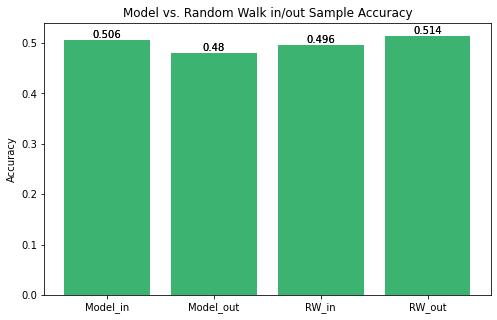

In [11]:
# Bar Graph
accs = np.round([train_acc, test_acc, in_rw_acc, out_rw_acc], 3)
indexes = ["Model_in", "Model_out", "RW_in", "RW_out"]
fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(indexes, accs, color='mediumseagreen')
ax.bar_label(bars)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Model vs. Random Walk in/out Sample Accuracy")
plt.ylabel("Accuracy")
plt.show()

## 4. [Problem has been removed]

## 5. Write an observation/conclusion about the graphs from Q3.

From the bar graph in question 3, it is immediately clear that our recurrent neural network was unable to outperform a simple random walk. The random walk model had an testing accuracy of about 51 percent to our neural network's 48%. The results are close, but this is, itself, an indictment of our model. It cannot outperform a simple guess. This result is expected since many neural networks do not perform well on stock market data.

Although, in defense of neural networks, we only tested one specific implementation of a RNN without any hyper-parameter tuning. It is possible that we see improvements with a better RNN.

## 6. Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5, 10, 20 days of previous price data to forecast.

Firstly, I define a function that creates the RNN model. For this initial model, I am using just a single hidden layer to keep things simple. Additionally, as per question specifications, I created a parameter for the number of lags in the input layer `timesteps`. This parameter shows up in the hyperparameter tuning section and will be tuned to either 5, 10, or 20 days.

After doing this first implementation, I will then do it again but this time with a new function that creates a RNN model with 3 hidden layers and with the dropout rate as a new paramter. In this second implementation, the grid search will optimize over the same `timesteps` but will now also incorporate `dropout_rate`.

#### First Implementation

In [12]:
# Define function that creates RNN model
def create_rnn_model(timesteps):
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(timesteps, 1)))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
# Wrap the Keras model in a scikit-learn classifier object
rnn_classifier = KerasClassifier(build_fn=create_rnn_model)

In [14]:
# Define the hyperparameters to search over
param_grid = {'timesteps': [5, 10, 20],
              'batch_size': [32, 64],
              'epochs': [10, 20]}

In [15]:
# Use GridSearchCV to perform the hyperparameter search
grid_search = GridSearchCV(estimator=rnn_classifier,
                            param_grid=param_grid,
                            cv=3)
grid_search.fit(x_train, y_train)

Epoch 1/10
97/97 [==============================] - 3s 4ms/step - loss: 0.6932 - accuracy: 0.5026
Epoch 2/10
97/97 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5142
Epoch 3/10
97/97 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5142
Epoch 4/10
97/97 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5142
Epoch 5/10
97/97 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5142
Epoch 6/10
97/97 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5142
Epoch 7/10
97/97 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5142
Epoch 8/10
97/97 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5142
Epoch 9/10
97/97 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5142
Epoch 10/10
49/49 [==============================] - 1s 2ms/step - loss: 0.6942 - accuracy: 0.4897
Epoch 1/10
97/97 [=

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000002AD4119AB80>,
             param_grid={'batch_size': [32, 64], 'epochs': [10, 20],
                         'timesteps': [5, 10, 20]})

In [16]:
# Print the best hyperparameters and corresponding test set accuracy
print('Best hyperparameters:', grid_search.best_params_)
print('Test set accuracy:', grid_search.best_score_)

Best hyperparameters: {'batch_size': 32, 'epochs': 20, 'timesteps': 5}
Test set accuracy: 0.5066906114419302


We can see from the above results that the best hyperparamter (of interest to us) is that **the optimal number of lags is 5 days**. Now we will move on to our second implementation where we also tune over `dropout_rate`.

#### Second Implementation

In [17]:
# Define a function that creates RNN model
def create_rnn_model(timesteps, dropout_rate):
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(timesteps, 1),
                    dropout=dropout_rate, recurrent_dropout=dropout_rate,
                    return_sequences=True))
    model.add(LSTM(units=32,
                    dropout=dropout_rate, recurrent_dropout=dropout_rate,
                    return_sequences=True))
    model.add(LSTM(units=16,
                    dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Wrap the Keras model in a scikit-learn classifier object
rnn_classifier = KerasClassifier(build_fn=create_rnn_model)

# Define the hyperparameters to search over
param_grid = {'timesteps': [5, 10, 20],
              'batch_size': [32, 64],
              'epochs': [10, 20],
              'dropout_rate': [0.2, 0.5]}

# Use GridSearchCV to perform the hyperparameter search
grid_search = GridSearchCV(estimator=rnn_classifier,
                            param_grid=param_grid,
                            cv=3)
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and corresponding test set accuracy
print('Best hyperparameters:', grid_search.best_params_)
print('Test set accuracy:', grid_search.best_score_)

Epoch 1/10
97/97 [==============================] - 11s 9ms/step - loss: 0.6932 - accuracy: 0.5123
Epoch 2/10
97/97 [==============================] - 1s 9ms/step - loss: 0.6929 - accuracy: 0.5142
Epoch 3/10
97/97 [==============================] - 1s 10ms/step - loss: 0.6929 - accuracy: 0.5142
Epoch 4/10
97/97 [==============================] - 1s 12ms/step - loss: 0.6930 - accuracy: 0.5142
Epoch 5/10
97/97 [==============================] - 1s 9ms/step - loss: 0.6932 - accuracy: 0.5142
Epoch 6/10
97/97 [==============================] - 1s 9ms/step - loss: 0.6929 - accuracy: 0.5142
Epoch 7/10
97/97 [==============================] - 1s 10ms/step - loss: 0.6929 - accuracy: 0.5142
Epoch 8/10
97/97 [==============================] - 1s 11ms/step - loss: 0.6928 - accuracy: 0.5142
Epoch 9/10
97/97 [==============================] - 1s 11ms/step - loss: 0.6928 - accuracy: 0.5142
Epoch 10/10
49/49 [==============================] - 1s 3ms/step - loss: 0.6941 - accuracy: 0.4897
Epoch 1/10
97

In [18]:
print('Best hyperparameters:', grid_search.best_params_)
print('Test set accuracy:', grid_search.best_score_)

Best hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'timesteps': 5}
Test set accuracy: 0.5060432155927023


From the above printout, we see that **still our optimal number of lags is 5 days**. But in addition, we see that a **dropout rate of 0.2 is also optimal**. Interestingly, this more complex model with 3 hidden layers and dropout performed *worse* than our simpler first implementation. This may have been a case of overfitting.

Importantly, **neither the first nor the second implementation of this cross-validated RNN outperformed the Random Walk from before**.

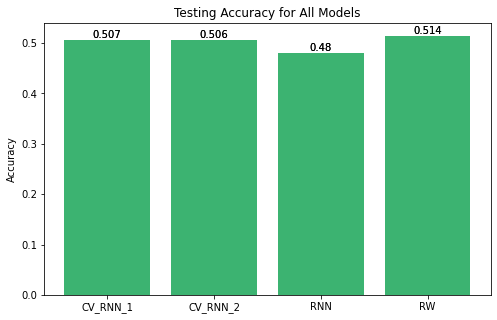

In [19]:
# Bar Graph with all models
accs = np.round([0.50669, 0.50604, test_acc, out_rw_acc], 3)
indexes = ["CV_RNN_1", "CV_RNN_2", "RNN", "RW"]
fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(indexes, accs, color='mediumseagreen')
ax.bar_label(bars)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Testing Accuracy for All Models")
plt.ylabel("Accuracy")
plt.show()